# Sentiment Analysis on Mental Health Statements

## 1. Introduction
This notebook aims to analyze mental health-related statements and classify them into different categories such as `Anxiety`, `Depression`, `Suicidal`, `Stress`, and `Normal`. The workflow includes data preprocessing, cleaning, exploration, and preparation for modeling.


In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [164]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [165]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nihar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# 2. Loading the Dataset

In [168]:
data = pd.read_csv('../data/raw/sentiment_data.csv', index_col=0)

# 3. Basic Dataset Overview

In [169]:
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [170]:
data.shape

(53043, 2)

In [171]:
data.columns

Index(['statement', 'status'], dtype='object')

### Checking for Missing Values

In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [173]:
data.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


### Looking at status counts


In [174]:
data['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

# 4. Data Cleaning


### Removing Duplicate records


In [175]:
data[data.duplicated()].size

3888

In [176]:
data = data.drop_duplicates().reset_index(drop=True)
data[data.duplicated()].size

0

### Removing Null records


In [177]:
data.isna().sum()

statement    6
status       0
dtype: int64

In [178]:
data[data['statement'].isna()].groupby('status').size()

status
Anxiety                 1
Bipolar                 1
Normal                  1
Personality disorder    1
Stress                  1
Suicidal                1
dtype: int64

In [179]:
data = data.dropna().reset_index(drop=True)


In [180]:
data.isna().sum()

statement    0
status       0
dtype: int64

In [181]:
data[data.duplicated(subset='statement')].groupby('status').size()

status
Anxiety       6
Depression    7
Normal        1
Stress        3
Suicidal      3
dtype: int64

### Remove duplicate entries in the 'statement' column

In [182]:

data = data.drop_duplicates(subset='statement')

In [183]:
data[data.duplicated(subset='statement')].groupby('status').size()


Series([], dtype: int64)

In [184]:

data.shape

(51073, 2)

# 5. Exploratory Data Analysis (EDA)

In [185]:
data['status'].value_counts()

status
Normal                  16039
Depression              15087
Suicidal                10641
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

In [186]:
# Occurrences of each category
status_counts = data['status'].value_counts()


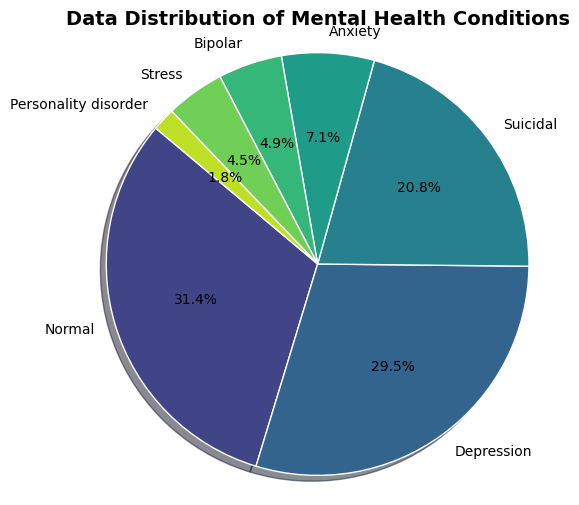

In [187]:

colors = colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(status_counts)))  
# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True, wedgeprops={'edgecolor': 'white'})

# Title
plt.title('Data Distribution of Mental Health Conditions', fontsize=14, fontweight='bold')

plt.axis('equal')
plt.show()


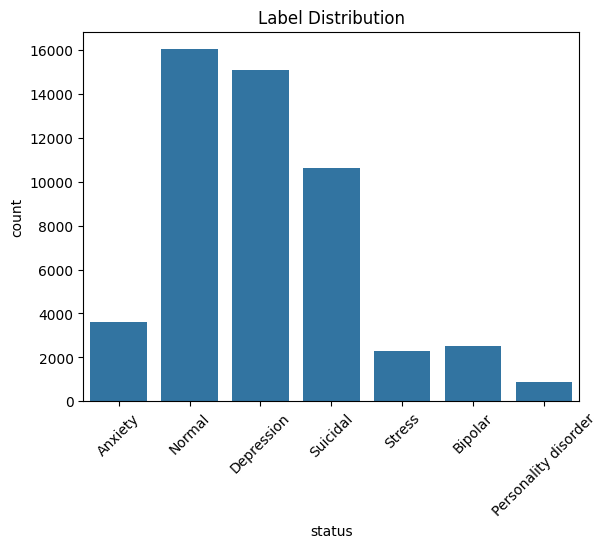

In [188]:
sns.countplot(x='status', data=data)
plt.xticks(rotation=45)  # If labels are long
plt.title('Label Distribution')
plt.show()

In [189]:
# Get a random statement from each group of status
random_statements = data.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])


In [190]:
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Those of you that Beat Cardiophobia, I Could use your Help... Hello,

Little bit of background. My younger brother has a weird heart issue. He needed a pacemaker/ICD at 21. Nobody else in my family has it, I've looked into it. I spent a whole summer getting second and third opinions from specialists in the field. I had 24 hr holter over the summer, excercise test and several EKGs. This kicked off my intense fear.

During the late fall, I started developing weird dizziness. I went to the ER twice, back to the cardiologist, everyone deemed it panic. I want to believe them. I'm trying.

The worst thing I've been doing is regularly checking my pulse, and it's always changing. The doctors don't seem to worried though. When I'm relaxed, or even just sitting and anxious, it can be 60. Sometimes it's 107. The more I focus on it, the more it fluctuates. I tried deleting the Samsung health app with the pulse ox but the curiosity always gets the better of me. I felt tir

#### The target variable is imbalanced, which could negatively impact model performance. A common rule of thumb is that if the minority class represents less than 2% of the total data, it may lead to biased predictions. We’ll need to address this imbalance using techniques like resampling, class weighting, or synthetic data generation to ensure fair and accurate results.

In [191]:
data.to_csv('../data/raw/cleaned_sentiment_data.csv', index=False)


## Stratified Sampling for Train-Test Split

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit


In [149]:
X = data.drop(columns=['status'])  # features
y = data['status']

# Create a stratified shuffle split with 1 iteration
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Now combine them back into train/test DataFrames
train_df = pd.concat([X_train, y_train], axis=1)
test_df  = pd.concat([X_test,  y_test],  axis=1)

print("Train shape:", train_df.shape)
print("Test shape:",  test_df.shape)

Train shape: (40858, 2)
Test shape: (10215, 2)


In [101]:
# Save train and test DataFrames to CSV files
train_df.to_csv('../data/raw/train_data.csv', index=False)
test_df.to_csv('../data/raw/test_data.csv', index=False)

print("Train and test datasets saved successfully!")


Train and test datasets saved successfully!


In [48]:
train_data = pd.read_csv('../data/raw/train_data.csv')
test_data = pd.read_csv('../data/raw/test_data.csv')

# 6. Text - Data Preprocessing for EDA

In [49]:
# Calculate the number of characters and sentences
train_data['num_of_characters'] = train_data['statement'].str.len()
train_data['num_of_sentences'] = train_data['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = train_data[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

       num_of_characters  num_of_sentences
count       40858.000000      40858.000000
mean          577.423442          6.270131
std           854.063217         11.127272
min             2.000000          1.000000
25%            79.000000          1.000000
50%           313.500000          3.000000
75%           751.000000          8.000000
max         32759.000000       1260.000000


In [50]:
train_data.head()

,statement,status,num_of_characters,num_of_sentences
0,I hate myself and do not understand why I shou...,Depression,604,8
1,I'M AT THE EDGE i have been having chronic ten...,Stress,505,5
2,i wish i was free that night. i'm kind of mad ...,Normal,63,2
3,I do not know what to do anymore. I know there...,Suicidal,1264,15
4,i dont have long left this past month has been...,Suicidal,905,1


### Removing URLs, punctuation and special characters...

In [51]:
import re

def clean_text(text):
    """
    Cleans the text by:
    - Removing URLs, markdown links, and user handles (@mentions)
    - Converting text to lowercase
    - Removing punctuation, numbers, and extra whitespace
    """
    if isinstance(text, str):  # Ensure input is a string
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)  # Remove markdown links
        text = re.sub(r'@\w+', '', text)  # Remove @mentions
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = ' '.join(text.split())  # Remove extra spaces
        return text
    return ''


In [52]:
# Apply the cleaning function to the 'statement' column
train_data['cleaned_text'] = train_data['statement'].apply(clean_text)

# Display a sample
train_data[['statement', 'cleaned_text']].head(10)


,statement,cleaned_text
0,I hate myself and do not understand why I shou...,i hate myself and do not understand why i shou...
1,I'M AT THE EDGE i have been having chronic ten...,im at the edge i have been having chronic tens...
2,i wish i was free that night. i'm kind of mad ...,i wish i was free that night im kind of mad th...
3,I do not know what to do anymore. I know there...,i do not know what to do anymore i know there ...
4,i dont have long left this past month has been...,i dont have long left this past month has been...
5,hiiragi shinya why is your life story so tragic,hiiragi shinya why is your life story so tragic
6,Hi I just woke up,hi i just woke up
7,Scared of Crohn's Disease I had a canker sore ...,scared of crohns disease i had a canker sore i...
8,i had a stomachache.,i had a stomachache
9,I went on a week long Mexico vacation with my ...,i went on a week long mexico vacation with my ...


### Tokenization

In [53]:
# Apply word_tokenize to each element in the 'statement' column
train_data['tokens'] = train_data['statement'].apply(word_tokenize)
train_data.head()

,statement,status,num_of_characters,num_of_sentences,cleaned_text,tokens
0,I hate myself and do not understand why I shou...,Depression,604,8,i hate myself and do not understand why i shou...,"[I, hate, myself, and, do, not, understand, wh..."
1,I'M AT THE EDGE i have been having chronic ten...,Stress,505,5,im at the edge i have been having chronic tens...,"[I, 'M, AT, THE, EDGE, i, have, been, having, ..."
2,i wish i was free that night. i'm kind of mad ...,Normal,63,2,i wish i was free that night im kind of mad th...,"[i, wish, i, was, free, that, night, ., i, 'm,..."
3,I do not know what to do anymore. I know there...,Suicidal,1264,15,i do not know what to do anymore i know there ...,"[I, do, not, know, what, to, do, anymore, ., I..."
4,i dont have long left this past month has been...,Suicidal,905,1,i dont have long left this past month has been...,"[i, dont, have, long, left, this, past, month,..."


### Stemming

In [54]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)


# Apply the function to the 'tokens' column
train_data['tokens_stemmed'] = train_data['tokens'].apply(stem_tokens)

train_data.head()

,statement,status,num_of_characters,num_of_sentences,cleaned_text,tokens,tokens_stemmed
0,I hate myself and do not understand why I shou...,Depression,604,8,i hate myself and do not understand why i shou...,"[I, hate, myself, and, do, not, understand, wh...",i hate myself and do not understand whi i shou...
1,I'M AT THE EDGE i have been having chronic ten...,Stress,505,5,im at the edge i have been having chronic tens...,"[I, 'M, AT, THE, EDGE, i, have, been, having, ...",i 'm at the edg i have been have chronic tensi...
2,i wish i was free that night. i'm kind of mad ...,Normal,63,2,i wish i was free that night im kind of mad th...,"[i, wish, i, was, free, that, night, ., i, 'm,...",i wish i wa free that night . i 'm kind of mad...
3,I do not know what to do anymore. I know there...,Suicidal,1264,15,i do not know what to do anymore i know there ...,"[I, do, not, know, what, to, do, anymore, ., I...",i do not know what to do anymor . i know there...
4,i dont have long left this past month has been...,Suicidal,905,1,i dont have long left this past month has been...,"[i, dont, have, long, left, this, past, month,...",i dont have long left thi past month ha been t...


### Word Cloud Visualization

In [60]:
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Define color mapping for each status category
status_colors = {
    'Depression': 'red',
    'Anxiety': 'blue',
    'Normal': 'green',
    'Stress': 'purple',
    'Bipolar': 'orange',
    'Suicidal': 'pink'
}

# Function to dynamically assign colors based on status
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return status_colors.get(current_status, 'black')  # Default to black if status is unknown


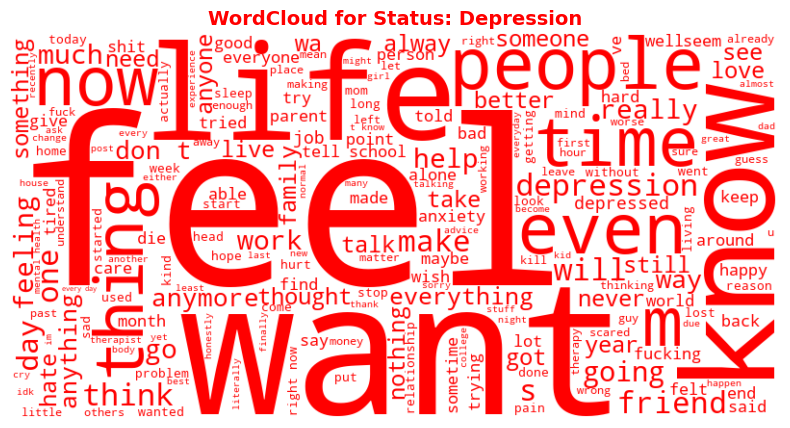

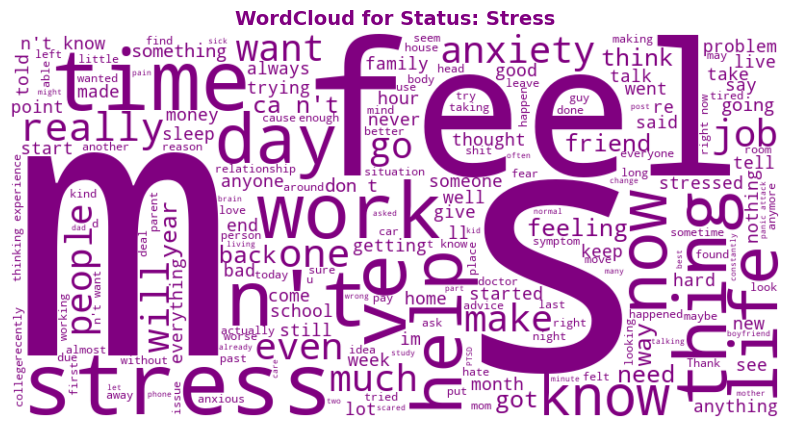

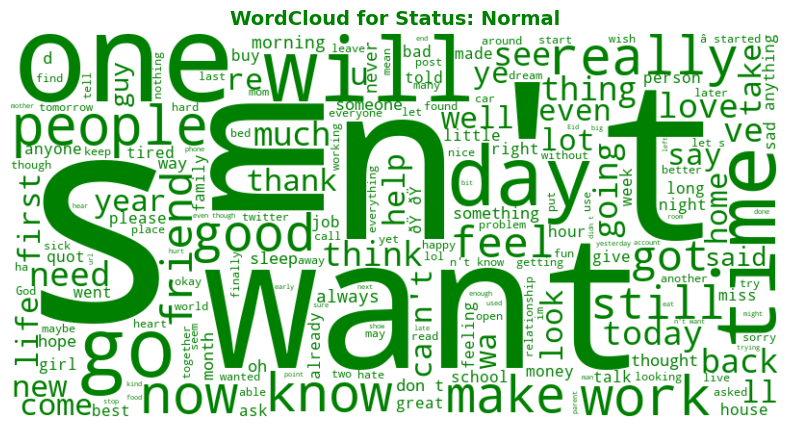

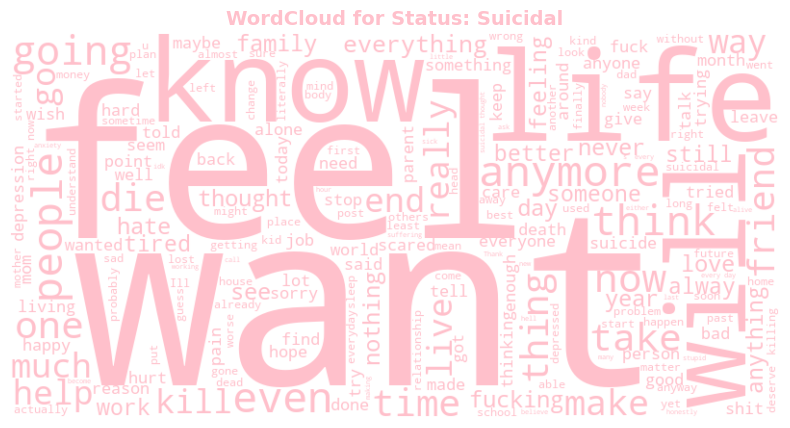

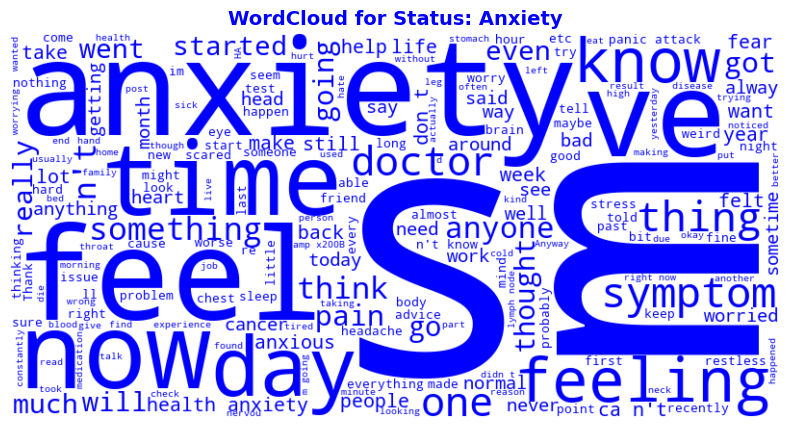

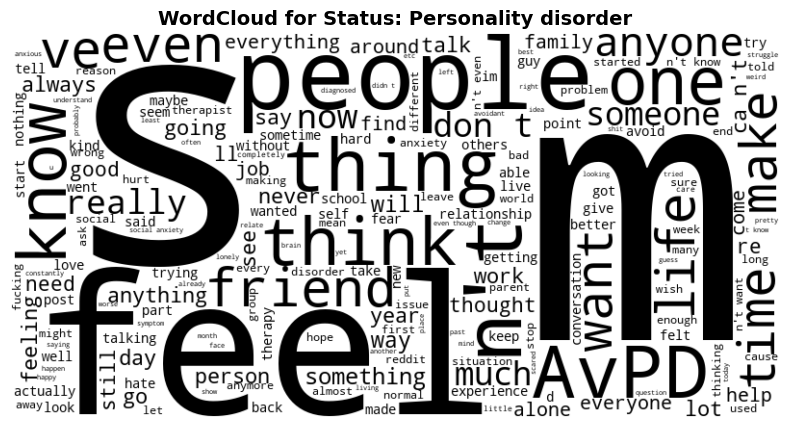

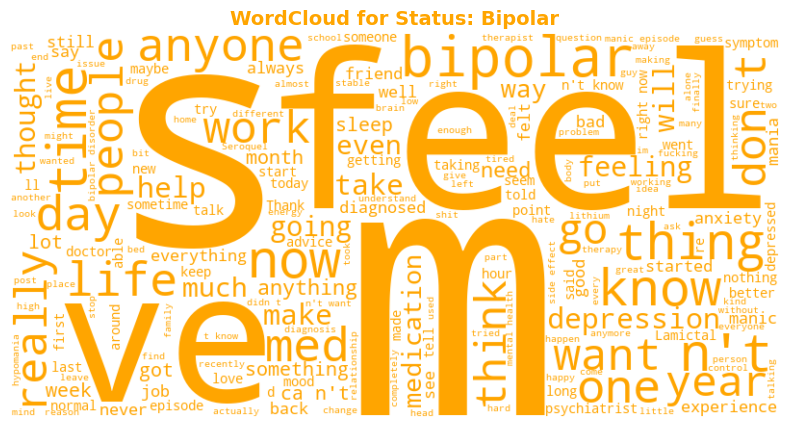

In [61]:

# Get unique statuses
statuses = train_data['status'].unique()

# Generate and plot the WordCloud for each category
for status in statuses:
    current_status = status  # Update global variable for color function
    
    # Filter tokens data for the current status
    tokens_data = ' '.join(train_data[train_data['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(
        width=800, height=400, 
        background_color='white',
        stopwords=STOPWORDS, 
        color_func=color_func
    ).generate(tokens_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}', fontsize=14, fontweight='bold', color=status_colors.get(status, 'black'))
    plt.show()

### Key Observations:
- **Overlap in Sentiment Categories:** Depression and Suicidal statuses share similar words, which can make classification harder.
- **Common Emotion Words:** "feel", "want", "life", "know" appear across all sentiments—stopword handling must be customized.
- **Strong Sentiment Words:** Words like "kill", "die", "pain", "end" are crucial for detecting extreme negative sentiment.
- **Context Matters:** 
  - **Stress & Anxiety:** Work-related concerns, symptoms.
  - **Bipolar & Personality Disorder:** More medical/diagnostic language.
